This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [3]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [4]:
all_data.head()

,Unnamed: 0,time_delta,soc_delta,soh,average_altitude,ground_speed,activity,average_power,id,unique_data_identifier,temperature,visibility,wind_speed
0,0,7.88,3.0,83,242.44,38.30,takeoff,57.27,5367,0,41.0,9.0,9
1,1,2.44,10.5,83,494.18,85.32,climb,48.63,5367,1,42.8,9.0,8
2,2,0.00,0.0,83,4.75,101.35,cruise,49.78,5367,2,42.8,9.0,8
3,3,0.00,0.0,83,4.76,100.74,climb,49.72,5367,3,41.0,9.0,9
4,4,0.00,0.0,83,4.95,100.56,cruise,49.64,5367,4,42.8,9.0,8


In [5]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 1215 
 Length train_y = 522


One-Hot-Encoding of the Operations columns

In [6]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['unique_data_identifier'] = df['unique_data_identifier']
  return encoded

In [7]:
# Encode Train data
train_encoded = one_hot(train_data, "activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["unique_data_identifier"])
final_train_y = final_train_x["soc_delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

# Encode Test data
test_encoded = one_hot(test_data, "activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["unique_data_identifier"])
final_test_y = final_test_x["soc_delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

In [8]:
final_train_x

,time_delta,soh,average_altitude,ground_speed,average_power,temperature,visibility,wind_speed,activity_is_climb,activity_is_cruise,activity_is_descent,activity_is_landing,activity_is_power off stall,activity_is_power on stall,activity_is_slow flight,activity_is_steep turns,activity_is_takeoff
0,0.00,94,5.16,68.13,30.08,50.0,9.0,8,False,True,False,False,False,False,False,False,False
1,0.04,90,4.58,55.90,11.47,55.4,9.0,6,False,False,False,True,False,False,False,False,False
2,0.98,97,206.99,75.46,58.20,66.2,9.0,4,False,False,False,False,False,False,False,False,True
3,0.08,96,1.93,83.39,19.59,53.6,3.0,3,False,False,False,False,False,False,False,False,True
4,0.58,90,-3.77,85.61,19.01,42.8,9.0,10,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,1.00,98,153.09,72.00,47.75,53.6,9.0,2,False,False,False,False,False,False,False,False,True
1211,3.04,97,-187.93,0.00,45.03,48.2,7.0,4,False,False,False,False,False,False,False,False,True
1212,1.22,96,220.88,71.30,47.10,42.8,7.0,0,True,False,False,False,False,False,False,False,False
1213,0.00,96,-0.99,55.99,1.90,53.6,1.5,2,False,False,False,False,False,False,False,False,True


In [9]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 522 
 Length train_encoded = 1215


In [10]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 1215 
 Length train_y = 1215


In [11]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 522 
 Length test_y = 522


Machine Learning Model Implementation

In [12]:
from sklearn.linear_model import Ridge

# Set model
ridge_model = Ridge(alpha=0.9)  # You can adjust the alpha parameter for regularization strength

# Fit model
ridge_model.fit(final_train_x, final_train_y)

Ridge(alpha=0.9)

In [13]:
# if there is no power on stall activities in test set, add the column with all false values
if 'activity_is_power on stall' not in final_test_x.columns:
  final_test_x.insert(loc=final_test_x.columns.get_loc('activity_is_slow flight'), column='activity_is_power on stall', value=False)

In [14]:
# Make predictions using the testing set
y_pred = ridge_model.predict(final_test_x)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 6.442050838267788
Coefficient of Determination (R-squared): 0.6575715406576089
Cross-validated R-squared: 0.6141622213731266
Mean Absolute Error (MAE): 1.2928344742644764
Root Mean Squared Error (RMSE): 2.5381195476706346
K-fold Cross-validated R-squared: 0.6324687524149116


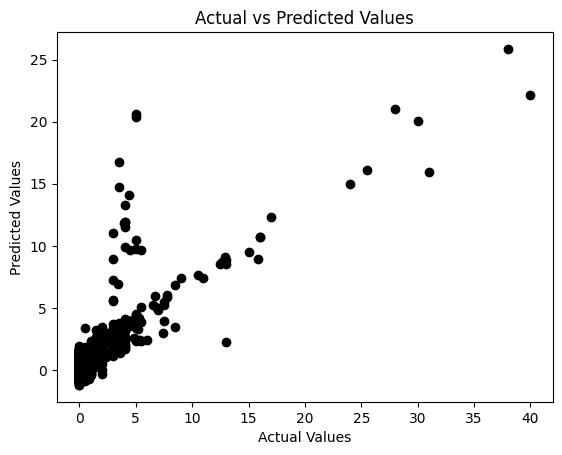

In [16]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

In [17]:
coeff = pd.DataFrame(list(zip(ridge_model.feature_names_in_, ridge_model.coef_)), columns = ['Feature', 'Weight'])
coeff.sort_values('Weight')

,Feature,Weight
16,activity_is_takeoff,-1.052871
11,activity_is_landing,-0.510316
14,activity_is_slow flight,-0.152478
12,activity_is_power off stall,-0.062209
10,activity_is_descent,-0.055368
7,wind_speed,-0.017288
1,soh,-0.007535
5,temperature,0.001985
3,ground_speed,0.003183
2,average_altitude,0.005481


In [18]:
import joblib

model_filename = 'ML_model_outputs/prescription_ridgereg_model.joblib'
joblib.dump(ridge_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ML_model_outputs/prescription_ridgereg_model.joblib
